### EDA on Political Bias in reporting:
I will be using the dataset created by: Baly et al.
- https://github.com/ramybaly/Article-Bias-Prediction
- https://paperswithcode.com/dataset/article-bias-prediction

Things I want to investigate specifically:
- Biases in reporting
- Ways to distinguish between political leanings

Potential Angles:
- Simple NB?
- Sentiment Analysis
- Embedding Clustering (tSNE / UMAP?)
- Lexical Choice

Also potentially interesting:
- Drift over time. You can EASILY imagine how sentiment from each side would vary over time over the last 10 years... (admin changes, etc.)


In [1]:
!git clone https://github.com/ramybaly/Article-Bias-Prediction

fatal: destination path 'Article-Bias-Prediction' already exists and is not an empty directory.


In [2]:
# pip installs. Some of these are likely overkill, im working in colab with most of these auto installed.
!pip install -U sentence-transformers
!pip install nltk
!pip install umap-learn
# !pip install seaborn
# !pip install matplotlib
# !pip install transformers
# !pip install torch
# !pip install pandas
# !pip install numpy

In [3]:
# imports...
import os
import json
import numpy as np
import pandas as pd

import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

###### Stage 1: Data Loading and Mild Exploration
---

Loading data, and taking a look at structure.

In [4]:
# folders for later
repo_file = "Article-Bias-Prediction"
data_folder = f"{repo_file}/data" # has childs: jsons (article data) and spltis (metadata about train/test splits)
json_folder = f"{data_folder}/jsons"
# structure of articles:
# { topic: , source: , bias: , url: , title: , date: , authors: , content: , content_original: , source_url : , bias_text: , id: }
# sample: https://github.com/ramybaly/Article-Bias-Prediction/blob/main/data/jsons/0DEXAqIIQ76eTtie.json

article_filenames = [ json_folder + "/" + name for name in os.listdir(json_folder) ]
print(article_filenames[:5])
print(len(article_filenames))
with open(article_filenames[0]) as f:
  article = json.load(f)
  print(article)

['Article-Bias-Prediction/data/jsons/peRZhTD9vzTp8O1d.json', 'Article-Bias-Prediction/data/jsons/YbjXUFS4wyOLUW8p.json', 'Article-Bias-Prediction/data/jsons/MqzlQQeKi22xUXUe.json', 'Article-Bias-Prediction/data/jsons/s0v3ZUkmTdeP8gZS.json', 'Article-Bias-Prediction/data/jsons/lpPEXdGo6rs8Fr7Q.json']
37554
{'topic': 'elections', 'source': 'NPR Online News', 'bias': 1, 'url': 'https://www.npr.org/2019/11/21/781502024/5-takeaways-from-the-5th-democratic-debate', 'title': '5 Takeaways From The 5th Democratic Debate', 'date': '2019-11-21', 'authors': 'Domenico Montanaro', 'content': "Candidates seeking the Democratic presidential nomination took to the debate stage for the fifth time Wednesday night . There were n't any groundbreaking or game-changing moments , but here are five things that stood out :\n1 . Impeachment hearings may have taken some steam out of the debate\nLet 's face it : The biggest story of Wednesday was not the debate , it was the impeachment testimony of Gordon Sondland

In [5]:
topics = set()
topic_to_filenames = {}

for filename in article_filenames:
  with open(filename) as f:
    article = json.load(f)
    topics.add(article["topic"])
    if article["topic"] not in topic_to_filenames:
      topic_to_filenames[article["topic"]] = []
    topic_to_filenames[article["topic"]].append(filename)

print(len(topics))
print(topics)

108
{'capital_punishment_and_death_penalty', 'supreme_court', 'fbi', 'gun_control_and_gun_rights', 'economy_and_jobs', 'immigration', 'banking_and_finance', 'world', 'dea', "women's_issues", 'us_senate', 'holidays', 'tea_party', 'criminal_justice', 'fake_news', 'national_security', 'south_korea', 'trade', 'russia', 'animal_welfare', 'republican_party', 'fda', 'social_security', 'facts_and_fact_checking', 'us_house', 'national_defense', 'democratic_party', 'palestine', 'epa', 'treasury', 'elections', 'free_speech', 'fiscal_cliff', 'obesity_and_malnutrition', 'violence_in_america', 'transportation', 'asia', 'welfare', 'state_department', 'white_house', 'inequality', 'healthcare', 'us_congress', 'culture', 'us_military', 'voting_rights_and_voter_fraud', 'race_and_racism', 'general_news', 'africa', 'campaign_finance', 'foreign_policy', 'politics', 'china', 'abortion', 'ebola', 'coronavirus', 'religion_and_faith', 'campaign_rhetoric', 'science', 'terrorism', 'cia', 'civil_rights', 'great_br

In [6]:
topic_counts = {topic: len(filenames) for topic, filenames in topic_to_filenames.items()}
topic_df = pd.DataFrame.from_dict(topic_counts, orient='index', columns=['article_count'])
topic_df = topic_df.sort_values(by='article_count', ascending=False)
topic_df.describe()

,article_count
count,108.000000
mean,347.722222
std,659.137568
min,5.000000
25%,62.000000
50%,154.000000
75%,367.500000
max,5624.000000


In [7]:
largest = topic_df.nlargest(10, 'article_count')
largest_topics = largest.index.tolist() # ['elections', 'politics', 'white_house', 'immigration', 'healthcare', 'media_bias', 'coronavirus', 'middle_east', 'gun_control_and_gun_rights', 'supreme_court']
smallest = topic_df.nsmallest(10, 'article_count')
print(f"Largest:\n{largest}\n\n")
print(f"Smallest:\n{smallest}")

Largest:
                            article_count
elections                            5624
politics                             2793
white_house                          1879
immigration                          1547
healthcare                           1374
media_bias                           1280
coronavirus                          1079
middle_east                           859
gun_control_and_gun_rights            850
supreme_court                         803


Smallest:
                                      article_count
dea                                               5
capital_punishment_and_death_penalty              9
south_korea                                      12
obesity_and_malnutrition                         13
fda                                              13
family_and_marriage                              14
africa                                           15
welfare                                          17
animal_welfare                                   

In [8]:
print("Insights on reporting bias on top issues: (left, center, right)")
for row in largest.iterrows():
  topic = row[0]
  filenames = topic_to_filenames[topic]
  biases = [0,0,0] # left, center, right
  for fname in filenames:
      with open(fname) as f:
          article = json.load(f)
          biases[article["bias"]] += 1
  blend = [ f"{(frac / len(filenames)):.3f}" for frac in biases]
  print(f"{topic}: {biases} - {blend}")

Insights on reporting bias on top issues: (left, center, right)
elections: [2387, 1392, 1845] - ['0.424', '0.248', '0.328']
politics: [950, 772, 1071] - ['0.340', '0.276', '0.383']
white_house: [645, 528, 706] - ['0.343', '0.281', '0.376']
immigration: [486, 411, 650] - ['0.314', '0.266', '0.420']
healthcare: [518, 258, 598] - ['0.377', '0.188', '0.435']
media_bias: [423, 218, 639] - ['0.330', '0.170', '0.499']
coronavirus: [349, 440, 290] - ['0.323', '0.408', '0.269']
middle_east: [259, 259, 341] - ['0.302', '0.302', '0.397']
gun_control_and_gun_rights: [247, 177, 426] - ['0.291', '0.208', '0.501']
supreme_court: [242, 285, 276] - ['0.301', '0.355', '0.344']


###### Stage 2: Sentiment Analysis Across Political Biasing
---

Could potentially clean up code, but might be unfruitful.
Quick exploration failed to reveal systematic differences.

Rabbits to chase:
- Further cleaning text input to sentiment analyzer:
  - Potential for testing with: lemmatization, stopwords, etc...

Fun visualizations though!

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

sia = SentimentIntensityAnalyzer()

In [10]:
# sia = SentimentIntensityAnalyzer()
# top topics... ['elections', 'politics', 'white_house', 'immigration', 'healthcare', 'media_bias', 'coronavirus', 'middle_east', 'gun_control_and_gun_rights', 'supreme_court']

# important!! this picks topic to focus on
topic = largest_topics[3] # immigration

topic_filenames = topic_to_filenames[topic]
print(topic_filenames[:5])

for fname in topic_filenames[:5]:
  with open(fname) as f:
    article = json.load(f)
    print(f"Analyzing article: {article['title']}")
    print(f"\t Source: {article['source']}, Bias: {article['bias']}")
    print(article["content"])
    print("\t", sia.polarity_scores(article["content"]))

['Article-Bias-Prediction/data/jsons/yfQVv7z7M3RwVIlD.json', 'Article-Bias-Prediction/data/jsons/aSVUilhNI74xq7e8.json', 'Article-Bias-Prediction/data/jsons/0vO5AqhuxpO0ajS7.json', 'Article-Bias-Prediction/data/jsons/m7SJXYS5y7wQqwKp.json', 'Article-Bias-Prediction/data/jsons/PpkTRdkkKRFdlwal.json']
Analyzing article: Trump slaps down Democrats' 'abolish ICE' push: 'It will never happen'
	 Source: Fox News, Bias: 2
President Trump is predicting that Democrats will be “ beaten so badly ” if they campaign on the policy of abolishing Immigration and Customs Enforcement ( ICE ) -- just as the once-fringe call to scrap the agency is going mainstream among the left .
In an interview to be aired Sunday with ███ ’ Maria Bartiromo on “ Sunday Morning Futures , ” Trump was asked what he thinks about more Democrats lining up to call for the agency ’ s abolition .
“ Well I hope they keep thinking about it . Because they ’ re going to get beaten so badly , ” he said . “ You know ICE , these are the

In [11]:
bias_counts = [0, 0, 0]

compiled_biases = [{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0} for _ in range(3)]
for fname in topic_filenames:
  with open(fname) as f:
    article = json.load(f)
    scores = sia.polarity_scores(article["content"])
    b = article["bias"]
    for key in scores:
      compiled_biases[b][key] += scores[key]
    bias_counts[b] += 1

# Normalize:
avg_bias_sentiments = []
for b in range(3):
  if bias_counts[b] == 0:
    avg_bias_sentiments.append({key: 0 for key in compiled_biases[b]})
  else:
    avg_bias_sentiments.append({key: compiled_biases[b][key] / bias_counts[b]
                                for key in compiled_biases[b]})

df = pd.DataFrame(avg_bias_sentiments, index=['left', 'center', 'right'])
print(df)

             neg       neu       pos  compound
left    0.079202  0.827150  0.093634  0.189483
center  0.078041  0.834876  0.087071  0.104316
right   0.092855  0.814646  0.092495 -0.049727


In [12]:
import numpy as np

# Initialize per-bias lists
sentiment_by_bias = {
    0: {'neg': [], 'neu': [], 'pos': [], 'compound': []},  # left
    1: {'neg': [], 'neu': [], 'pos': [], 'compound': []},  # center
    2: {'neg': [], 'neu': [], 'pos': [], 'compound': []}   # right
}

for fname in topic_filenames:
    with open(fname) as f:
        article = json.load(f)
        scores = sia.polarity_scores(article["content"])
        b = article["bias"]
        for key in scores:
            sentiment_by_bias[b][key].append(scores[key])

In [13]:
bias_labels = ['left', 'center', 'right']
bias_dfs = {}

for bias_num, label in enumerate(bias_labels):
    bias_dfs[label] = pd.DataFrame(sentiment_by_bias[bias_num])

for label in bias_labels:
    print(f"\n=== {label.upper()} ===")
    print(bias_dfs[label].describe())



=== LEFT ===
              neg         neu         pos    compound
count  486.000000  486.000000  486.000000  486.000000
mean     0.079202    0.827150    0.093634    0.189483
std      0.037923    0.042238    0.029540    0.912331
min      0.000000    0.599000    0.018000   -0.999900
25%      0.053000    0.805250    0.071000   -0.961750
50%      0.075000    0.827000    0.092000    0.888750
75%      0.099750    0.851000    0.113000    0.989675
max      0.281000    0.947000    0.209000    0.999800

=== CENTER ===
              neg         neu         pos    compound
count  411.000000  411.000000  411.000000  411.000000
mean     0.078041    0.834876    0.087071    0.104316
std      0.034104    0.038742    0.029395    0.926060
min      0.010000    0.721000    0.015000   -1.000000
25%      0.053000    0.809500    0.068000   -0.976600
50%      0.075000    0.836000    0.086000    0.796900
75%      0.098000    0.861500    0.107000    0.988100
max      0.222000    0.951000    0.174000    0.99960

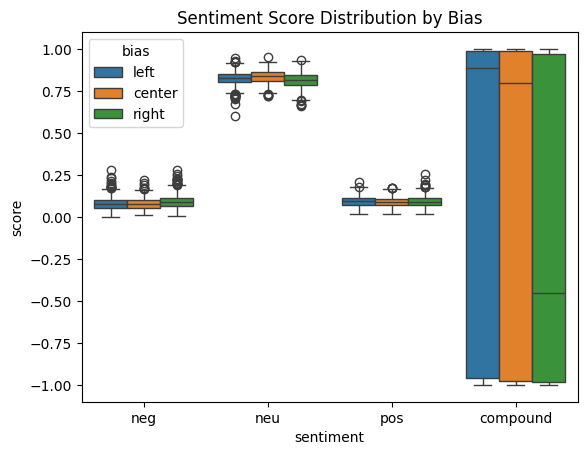

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add labels and flatten data
all_data = []
for bias, df in bias_dfs.items():
    for sentiment in ['neg', 'neu', 'pos', 'compound']:
        for val in df[sentiment]:
            all_data.append({'bias': bias, 'sentiment': sentiment, 'score': val})

plot_df = pd.DataFrame(all_data)

sns.boxplot(data=plot_df, x='sentiment', y='score', hue='bias')
plt.title("Sentiment Score Distribution by Bias")
plt.show()


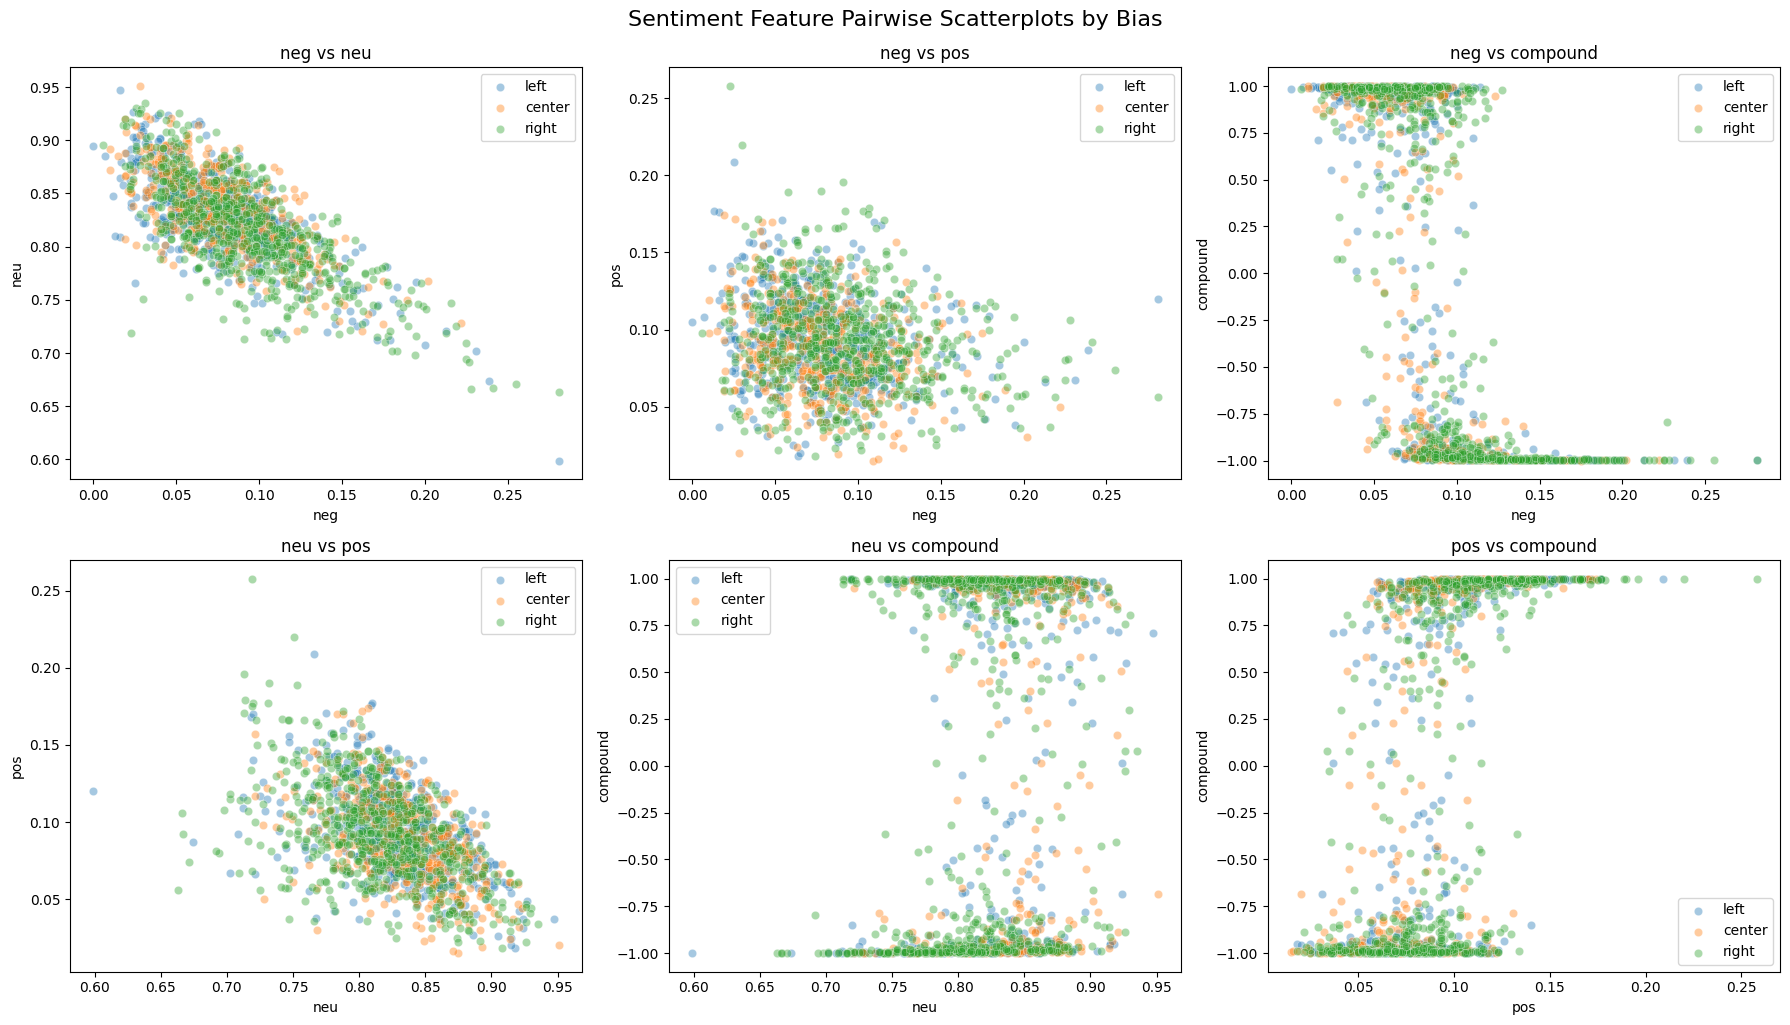

In [15]:
from itertools import combinations

features = ['neg', 'neu', 'pos', 'compound']
bias_labels = ['left', 'center', 'right']

# Create 6 pairwise plots in a 2x3 grid
pairs = list(combinations(features, 2))
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, (x_feat, y_feat) in zip(axes, pairs):
    for bias in bias_labels:
        sns.scatterplot(
            data=bias_dfs[bias],
            x=x_feat, y=y_feat,
            label=bias,
            alpha=0.4,
            ax=ax
        )
    ax.set_title(f"{x_feat} vs {y_feat}")
    ax.legend()

plt.tight_layout()
plt.suptitle("Sentiment Feature Pairwise Scatterplots by Bias", fontsize=16, y=1.02)
plt.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


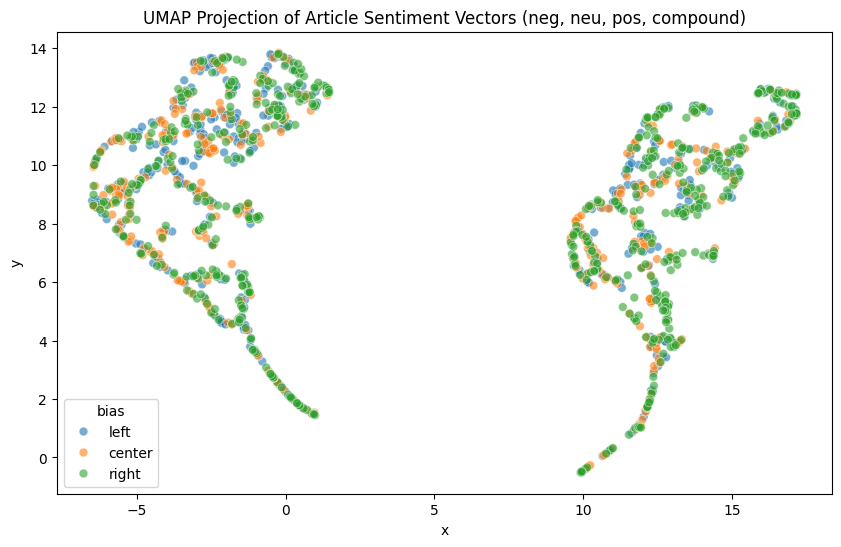

In [16]:
import umap

# Combine data from all bias groups
bias_labels = ['left', 'center', 'right']
all_vectors = []
all_biases = []

for label in bias_labels:
    df = bias_dfs[label]
    all_vectors.append(df[['neg', 'neu', 'pos', 'compound']].values)
    all_biases.extend([label] * len(df))

X = np.vstack(all_vectors)  # shape: (n_samples, 4)
y = np.array(all_biases)

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)  # shape: (n_samples, 2)

umap_df = pd.DataFrame({
    'x': embedding[:,0],
    'y': embedding[:,1],
    'bias': y
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=umap_df, x='x', y='y', hue='bias', alpha=0.6, s=40)
plt.title("UMAP Projection of Article Sentiment Vectors (neg, neu, pos, compound)")
plt.show()


##### Stage 3: Sentence Embeddings

In [20]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Model details: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
# - 256 token limit
# - 384 embedding dimension
# - 22M params
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def embed_article(article_text, chunk_size=256, stride=50):
    # Raw token list (not tensors)
    tokens = tokenizer.encode(article_text, add_special_tokens=False)
    chunks = []

    for i in range(0, len(tokens), stride):
        chunk = tokens[i:i+chunk_size]
        if len(chunk) < 10:
            continue  # skip small tail fragments
        chunk_input = tokenizer.decode(chunk, skip_special_tokens=True)
        encoded_input = tokenizer(chunk_input, padding=True, truncation=True, return_tensors='pt')

        with torch.no_grad():
            model_output = model(**encoded_input)
            embedding = mean_pooling(model_output, encoded_input['attention_mask'])
            chunks.append(embedding)

        if i + chunk_size >= len(tokens):
            break

    if not chunks:
        raise ValueError("No valid chunks found for article. Possibly too short.")

    article_embedding = torch.mean(torch.stack(chunks), dim=0)
    return F.normalize(article_embedding, p=2, dim=1)

for fname in topic_filenames[:5]:
  with open(fname) as f:
    article = json.load(f)
    print(f"Analyzing article: {article['title']}")
    print(f"\t Source: {article['source']}, Bias: {article['bias']}")
    # print(article["content"])
    print("\t", embed_article(article["content"]))


Token indices sequence length is longer than the specified maximum sequence length for this model (747 > 512). Running this sequence through the model will result in indexing errors


Analyzing article: Trump slaps down Democrats' 'abolish ICE' push: 'It will never happen'
	 Source: Fox News, Bias: 2
	 tensor([[-7.0422e-02, -9.1297e-03,  4.9697e-03, -1.3737e-02,  6.2441e-02,
         -1.2784e-02,  2.9603e-02, -4.5665e-02, -2.4972e-02, -3.5969e-02,
         -1.0817e-02,  9.5616e-02,  7.5304e-03,  1.1893e-02, -4.4575e-03,
          1.3110e-01, -1.1796e-02, -4.9926e-02, -6.9657e-02,  8.9361e-02,
         -3.3039e-02, -5.4491e-02,  1.5869e-02,  4.6094e-02,  3.6875e-03,
          7.3121e-02, -1.7569e-02, -4.3245e-03, -3.0048e-02,  1.9421e-02,
          7.0113e-02,  2.0707e-02,  1.4803e-02,  4.8390e-02,  7.3978e-02,
         -4.8936e-02,  5.5916e-02, -3.7073e-02,  3.9458e-02, -2.6991e-03,
          8.3051e-02, -5.7699e-02, -6.1133e-02,  3.8548e-02,  1.1519e-02,
          1.5824e-02,  2.9584e-03,  2.5699e-02, -2.1438e-02, -4.8276e-02,
          7.5975e-03, -7.7769e-03, -3.2002e-02,  3.6127e-02,  3.7233e-02,
         -8.3903e-03,  5.0878e-03, -4.1640e-03,  4.9549e-02,  3.69

/tmp/ipython-input-21-3599259600.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  embedding_matrix = torch.tensor(all_embeddings)
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


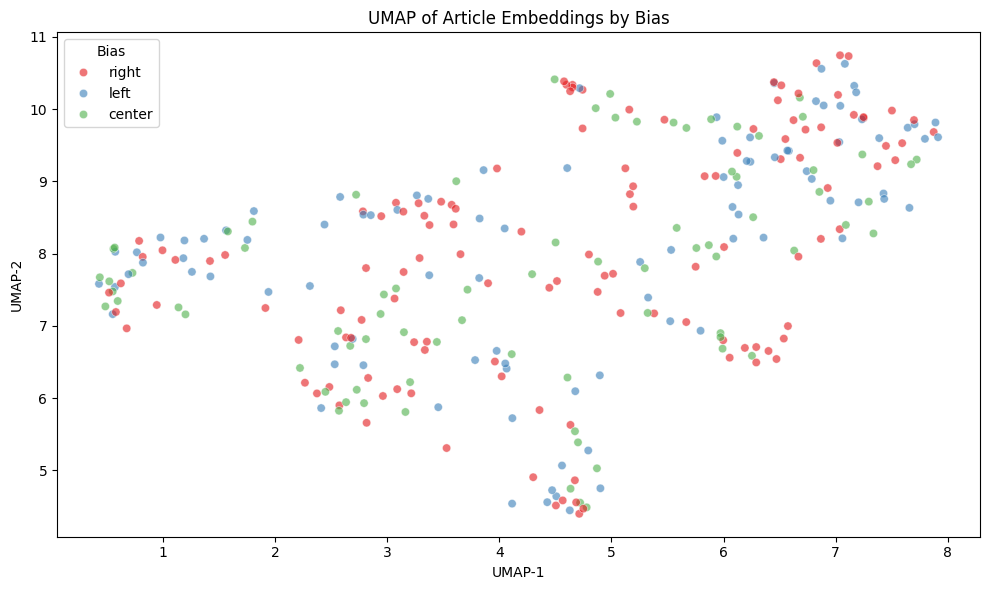

In [21]:
all_embeddings = []
all_biases = []

# SAMPLE: first N articles
N = 300  # adjust as needed
for fname in topic_filenames[:N]:
    with open(fname) as f:
        article = json.load(f)
        try:
            embedding = embed_article(article["content"])
            all_embeddings.append(embedding.squeeze().numpy())
            all_biases.append(article["bias"])
        except Exception as e:
            print(f"Skipping due to error: {e}")

# Stack into single tensor
embedding_matrix = torch.tensor(all_embeddings)


In [ ]:
# Run UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embedding_matrix)

# Make a DataFrame for plotting
df = pd.DataFrame(embedding_2d, columns=['x', 'y'])
df['bias'] = [ {0: 'left', 1: 'center', 2: 'right'}[b] for b in all_biases ]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='x', y='y', hue='bias', alpha=0.6, palette='Set1')
plt.title('UMAP of Article Embeddings by Bias')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend(title='Bias')
plt.tight_layout()
plt.show()

##### Stage 4: Lexical Choice
---

I'm very new to this part, so I will likely have to return to this.

Potential ideas?
- TF-IDF
- LIWC
- Empath
- Latent Semantic Analysis